# Converting Pennylane Python code into LLVM
Xanadu is a company using Photonic Quantum Computers, and Pennylane is the Python framework to run circuits on the Photonic Quantum Computer. For more information please click the following links:

1. Pennylane Framework **[HERE](https://pennylane.ai/).**
2. Xanadu Photonic Quantum Computer called Borealis **[HERE](https://www.xanadu.ai/products/borealis/).**
3. Xanadu x8 photonic chip is an 8 bit quantum computer **[HERE](https://strawberryfields.ai/photonics/demos/tutorial_X8.html).**


Here are some key aspects of the Xanadu x8 photonic chip:
1. Unlike superconducting qubits which need to be in an extremely cold environment, photonic quantum computers work at room temperature.
2. Can be integrated with current fiber optics telecommunications frameworks.
3. Can scale to hundreds of photonic based qubits.


Differences in qubit connectivity, decoherence times, etc. for a photonic quantum computer will cause the transpilation to look different than the transpilation for a superconducting quantum computer or an ion trap based quantum computer. The llvm will also look different. **But how will the llvm for a photonic quantum computer look different?** That is the purpose of this tutorial! Here are the steps to complete this analysis.

0. Write the Bernstein Vazirani algorithm for a 3 bit hidden string s, in Pennylane. This will also involve connecting the B-V pennylane circuit to one of Xanadus photonic quantum computers.
1. (Optional) Transpile B-V pennylane circuit.
2. Dump photonic specific instructions from the B-V pennylane circuit.
3. Convert photonic instructions into LLVM.

### **Step 0: Write the Bernstein Vazirani algorithm for a 3 bit hidden string s, in Pennylane.**

There are 3 options to accomplish this which are:
1. Write the simplified Bernstein Vazirani algorithm from scratch using pennylane.

2. **Write the simplified Bernstein Vazirani algorithm from scratch using Qiskit, then convert to pennylane.**

3. Write simplified Bernstein Vazirani algorithm from scratch using Qiskit, convert the Qiskit circuit to a pytket circuit, convert the pytket circuit to an amazon braket circuit, lastly convert the amazon braket circuit to a pennylane circuit.

For the purposes of this example, we will do **Option 2**.

In [ ]:
# Option 1: Write the simplified Bernstein Vazirani algorithm from scratch using pennylane
#import pennylane as qml
# INTENTIONALLY LEFT BLANK.


In [1]:
# Write simplified Bernstein Vazirani algorithm from scratch using Qiskit
from qiskit import QuantumCircuit
from qiskit.visualization import circuit_drawer
from qiskit.compiler import transpile


s = '011'   # the hidden binary string
n = 3 # number of bits used to represent s


# We need a circuit with n qubits, plus one auxiliary qubit
# We also need n classical bits to write the output to
qiskit_untranspiled_qc = QuantumCircuit(n+1, n)

# Put auxiliary in the minus state |->
# We leave the other n qubits in just |0>
qiskit_untranspiled_qc.h(n)
qiskit_untranspiled_qc.z(n)

# Apply Hadamard gates to each of the n "main" qubits (excluding the auxiliary)
# before querying the oracle
for i in range(n):
    qiskit_untranspiled_qc.h(i)
    
# Apply barrier
qiskit_untranspiled_qc.barrier()

# Apply the inner-product oracle
s = s[::-1] # reverse s to fit qiskit's qubit ordering
for q in range(n):
    if s[q] == '0':
        qiskit_untranspiled_qc.i(q)
    else:
        qiskit_untranspiled_qc.cx(q, n)
        
# Apply barrier
qiskit_untranspiled_qc.barrier()

# Apply Hadamard gates after querying the oracle
for i in range(n):
    qiskit_untranspiled_qc.h(i)


# Measurement
for i in range(n):
    qiskit_untranspiled_qc.measure(i, i)


qiskit_untranspiled_qc = transpile(qiskit_untranspiled_qc, backend=None)  # No Optimization and no mapping because we have not specified a backend.
print('No Optimization')
print('Depth:', qiskit_untranspiled_qc.depth())
print('Gate counts:', qiskit_untranspiled_qc.count_ops())
qiskit_untranspiled_qc.draw()

No Optimization
Depth: 6
Gate counts: OrderedDict([('h', 7), ('measure', 3), ('barrier', 2), ('cx', 2), ('z', 1), ('id', 1)])


┌───┐      ░                 ░ ┌───┐┌─┐      
q_0: ┤ H ├──────░───■─────────────░─┤ H ├┤M├──────
     ├───┤      ░   │             ░ ├───┤└╥┘┌─┐   
q_1: ┤ H ├──────░───┼─────────■───░─┤ H ├─╫─┤M├───
     ├───┤      ░   │  ┌───┐  │   ░ ├───┤ ║ └╥┘┌─┐
q_2: ┤ H ├──────░───┼──┤ I ├──┼───░─┤ H ├─╫──╫─┤M├
     ├───┤┌───┐ ░ ┌─┴─┐└───┘┌─┴─┐ ░ └───┘ ║  ║ └╥┘
q_3: ┤ H ├┤ Z ├─░─┤ X ├─────┤ X ├─░───────╫──╫──╫─
     └───┘└───┘ ░ └───┘     └───┘ ░       ║  ║  ║ 
c: 3/═════════════════════════════════════╩══╩══╩═
                                          0  1  2

#### **Install necessary plugins**

Must download the following plugins: 
1. Pennylane plugin. For more information click **[HERE](https://pennylane.ai/install.html).**
        a. pip install pennylane --upgrade
2. Pennylane-Qiskit plugin. Convert from qiskit to pennylane circuit. For more information click **[HERE](https://pennylaneqiskit.readthedocs.io/en/latest/installation.html).**
        a. pip install pennylane-qiskit

Its recommended to download these plugins in your terminal rather than through this jupyter notebook.

#### **Choose a Pennylane Backend**

In [2]:
import pennylane as qml
photonic_backend = qml.device('default.gaussian', wires=4, shots=1024) # Chose a fake pennylane backend JUST FOR NOW.

#### **Connect Pennylane circuit to one of Xanadus Photonic Quantum Computers.**
For more information about how to create a Pennylane quantum circuit, please click **[HERE](https://pennylane.readthedocs.io/en/stable/introduction/circuits.html).**

In [3]:
pennylane_untranspiled_qc = qml.from_qiskit(qiskit_untranspiled_qc) # Convert qiskit circuit to pennylane circuit.
print("Pennylane Circuit Object: ", pennylane_untranspiled_qc)

# Connect pennylane circuit to a Xanadu Backend.
@qml.qnode(photonic_backend) 
def pennylane_circuit():
    pennylane_untranspiled_qc(wires=[0, 1, 2, 3])
    return qml.probs(wires=[0, 1, 2])





'''
# Draw the circuit. Simple graphics.
circ = qml.QNode(pennylane_circuit, photonic_backend)
drawer = qml.draw(pennylane_circuit, show_all_wires=True, wire_order=[0,1,2,3])
print(drawer())
'''
probabilities = pennylane_circuit()
print("Probabilities: ", probabilities)


# Draw the circuit. Nicer graphics
import matplotlib.pyplot as plt
fig, ax = qml.draw_mpl(pennylane_circuit)()
plt.show()


Pennylane Circuit Object:  <function load.<locals>._function at 0x000001552E4A9EE0>


C:\Users\Danie\AppData\Roaming\Python\Python38\site-packages\pennylane_qiskit\converter.py:230: UserWarning: pennylane_qiskit.converter: The Barrier instruction is not supported by PennyLane, and has not been added to the template.
  warnings.warn(
C:\Users\Danie\AppData\Roaming\Python\Python38\site-packages\pennylane_qiskit\converter.py:230: UserWarning: pennylane_qiskit.converter: The Measure instruction is not supported by PennyLane, and has not been added to the template.
  warnings.warn(


DeviceError: Gate RZ not supported on device default.gaussian

Measurement Results using noiseless device. 

The **first entry** in the array, corresponds to the probability of measuring the **|000>** state. 

The **second entry** in the array, corresponds to the probability of measuring the **|001>** state. 

The **seventh entry** in the array, corresponds to the probability of measuring the **|011>** state.

### **Step 1: (Optional) Transpile B-V pennylane circuit.**


### **Step 2: Dump photonic specific instructions from the B-V pennylane circuit.**


### **Step 3: Convert photonic instructions into LLVM.**


# Come back to this after figuring out how to dump pennylane instructions for a Xanadu photonic quantum computer.

## Using Pennylanes real Photonic Device, Borealis

To submit a job to the Borealis Photonic Device, we have two options. For more information, please click **[HERE](https://strawberryfields.ai/photonics/demos/tutorial_X8.html#configuring-your-credentials).**
1. Log into Xanadu Cloud to access and execute this demo directly. 
2. Create a Xanadu Cloud account, generate an API key within Xanadu Cloud, and set up your cloud API key with Strawberry Fields.

We want to keep everything in this notebook, so we will do option #2. First you must make a Xanadu account **[HERE](https://platform.xanadu.ai/auth/realms/platform/protocol/openid-connect/registrations?client_id=public&redirect_uri=https%3A%2F%2Fcloud.xanadu.ai%2Flogin&response_type=code).**

Once your logged in, you will need to find your Personal Xanadu Cloud API key.
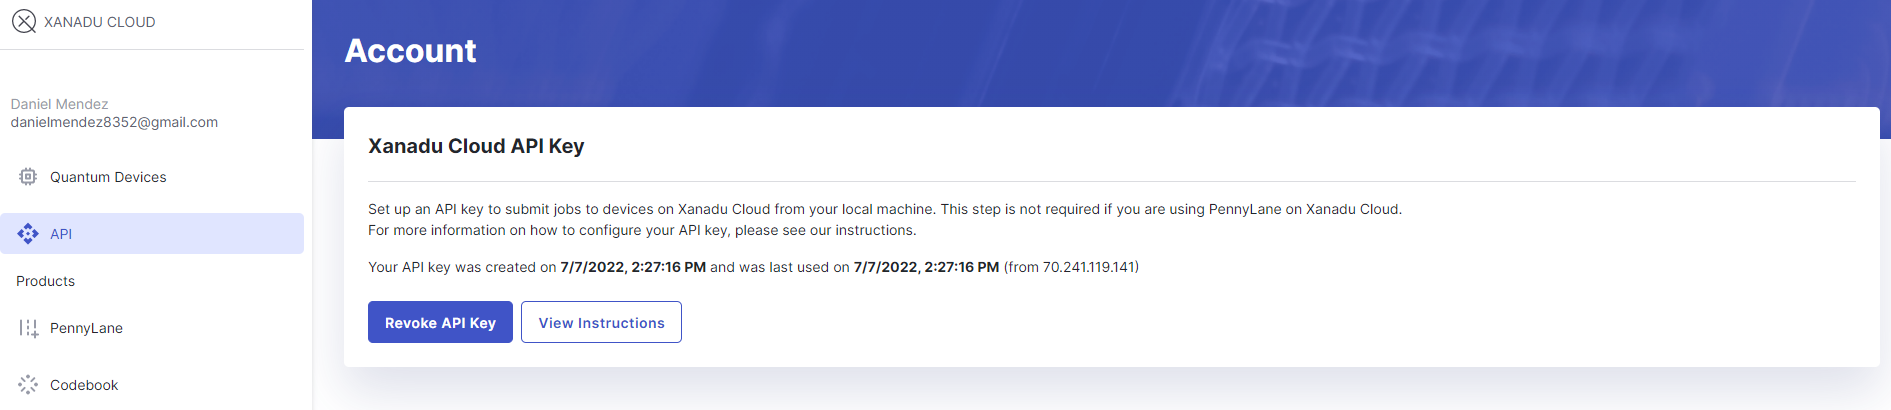

In [ ]:
import xcc
xcc.Settings(REFRESH_TOKEN="<Your Personal Xanadu API Token>").save()

import xcc.commands
xcc.commands.ping()

Strawberry fields plugin needed to use Borealis Device. For more information click **[HERE](https://pennylane-sf.readthedocs.io/en/latest/installation.html).**

        a. python -m pip install pennylane-sf

Its recommended to download this plugin in your terminal rather than through this jupyter notebook.

In [ ]:
# NOTE: STILL IN DEVELOPMENT.

import strawberryfields as sf
import numpy as np

eng = sf.RemoteEngine("borealis")
device = eng.device


# Convert qiskit circuit to pennylane circuit.
import pennylane as qml
photonic_backend = qml.device('default.qubit', wires=4, shots=1024)
pennylane_untranspiled_qc = qml.from_qiskit(qiskit_untranspiled_qc)

@qml.qnode(photonic_backend)
def pennylane_circuit():
    pennylane_untranspiled_qc(wires=[0, 1, 2, 3])
    return qml.probs(wires=[0, 1, 2])


probabilities = pennylane_circuit()
print("Probabilities: ", probabilities)

# Miscellaneous

In [ ]:

'''
# Convert the Qiskit circuit to a pytket circuit
from pytket.extensions.qiskit import qiskit_to_tk
from pytket.utils import Graph

pytket_untranspiled_qc = qiskit_to_tk(qiskit_untranspiled_qc)
Graph(pytket_untranspiled_qc).get_DAG() 

print(pytket_untranspiled_qc)
# Convert the pytket circuit to an amazon braket circuit
from pytket.extensions.braket import tk_to_braket
braket_untranspiled_qc = tk_to_braket(pytket_untranspiled_qc)

# Convert the amazon braket circuit to a pennylane circuit.
'''

#### Note: From Pennylane to OpenQASM

In [ ]:
import pennylane as qml

dev = qml.device("qiskit.aer", wires=1)

@qml.qnode(dev)
def f(x):
    qml.RX(x, wires=0)
    return qml.expval(qml.PauliZ(0))

f(0.3)

dev._circuit.qasm(formatted=True)